In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import smopy
import numpy as np
import folium
import datetime

# Load the data
df_incidents = pd.read_csv('df_incidents.csv')
df_poi = pd.read_csv('df_poi.csv')
df_incidents = df_incidents[df_incidents['categorie'] == 8]

In [218]:
BUFFER_SIZE = 300  # Buffer in meters
#geopy.distance.great_circle((x['coordinates_lat'], x['coordinates_lon']),(df_poi['lat'],df_poi['lon'])).meters < BUFFER_SIZE

Noms = df_poi['name'].to_list()
C = ''
for x in Noms:
    C = C + x + ' '
#Counting the number of occurence of each element in the list
D = {}
for i in C.split():
    if i in D:
        D[i] += 1
    else:
        D[i] = 1
#Taking the 2 elements of D with the highest value
NOM = []
for i in range(2):
    max_key = max(D, key=D.get)
    NOM.append(max_key + 's' if max_key[-1] != 's' or x else max_key + '')
    del D[max_key]
print(NOM)

['Crèches', 'Écoles']


In [219]:
# Creating a column to store the number of incidents
df_poi['Number of incidents'] = 0

# Calculate the distance between each incident and each POI
for i, poi in df_incidents.iterrows():
    for j, incident in df_poi.iterrows():
        distance = geopy.distance.great_circle((poi['latitude'], poi['longitude']),
                                               (incident['latitude'], incident['longitude'])).meters
        if distance < BUFFER_SIZE:
            df_poi['Number of incidents'][j] += 1

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='Number of incidents', ascending=False)

/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_69250/2267011712.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_poi['Number of incidents'][j] += 1
/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_69250/226701171

Lowered zoom level to keep map size reasonable. (z = 12)


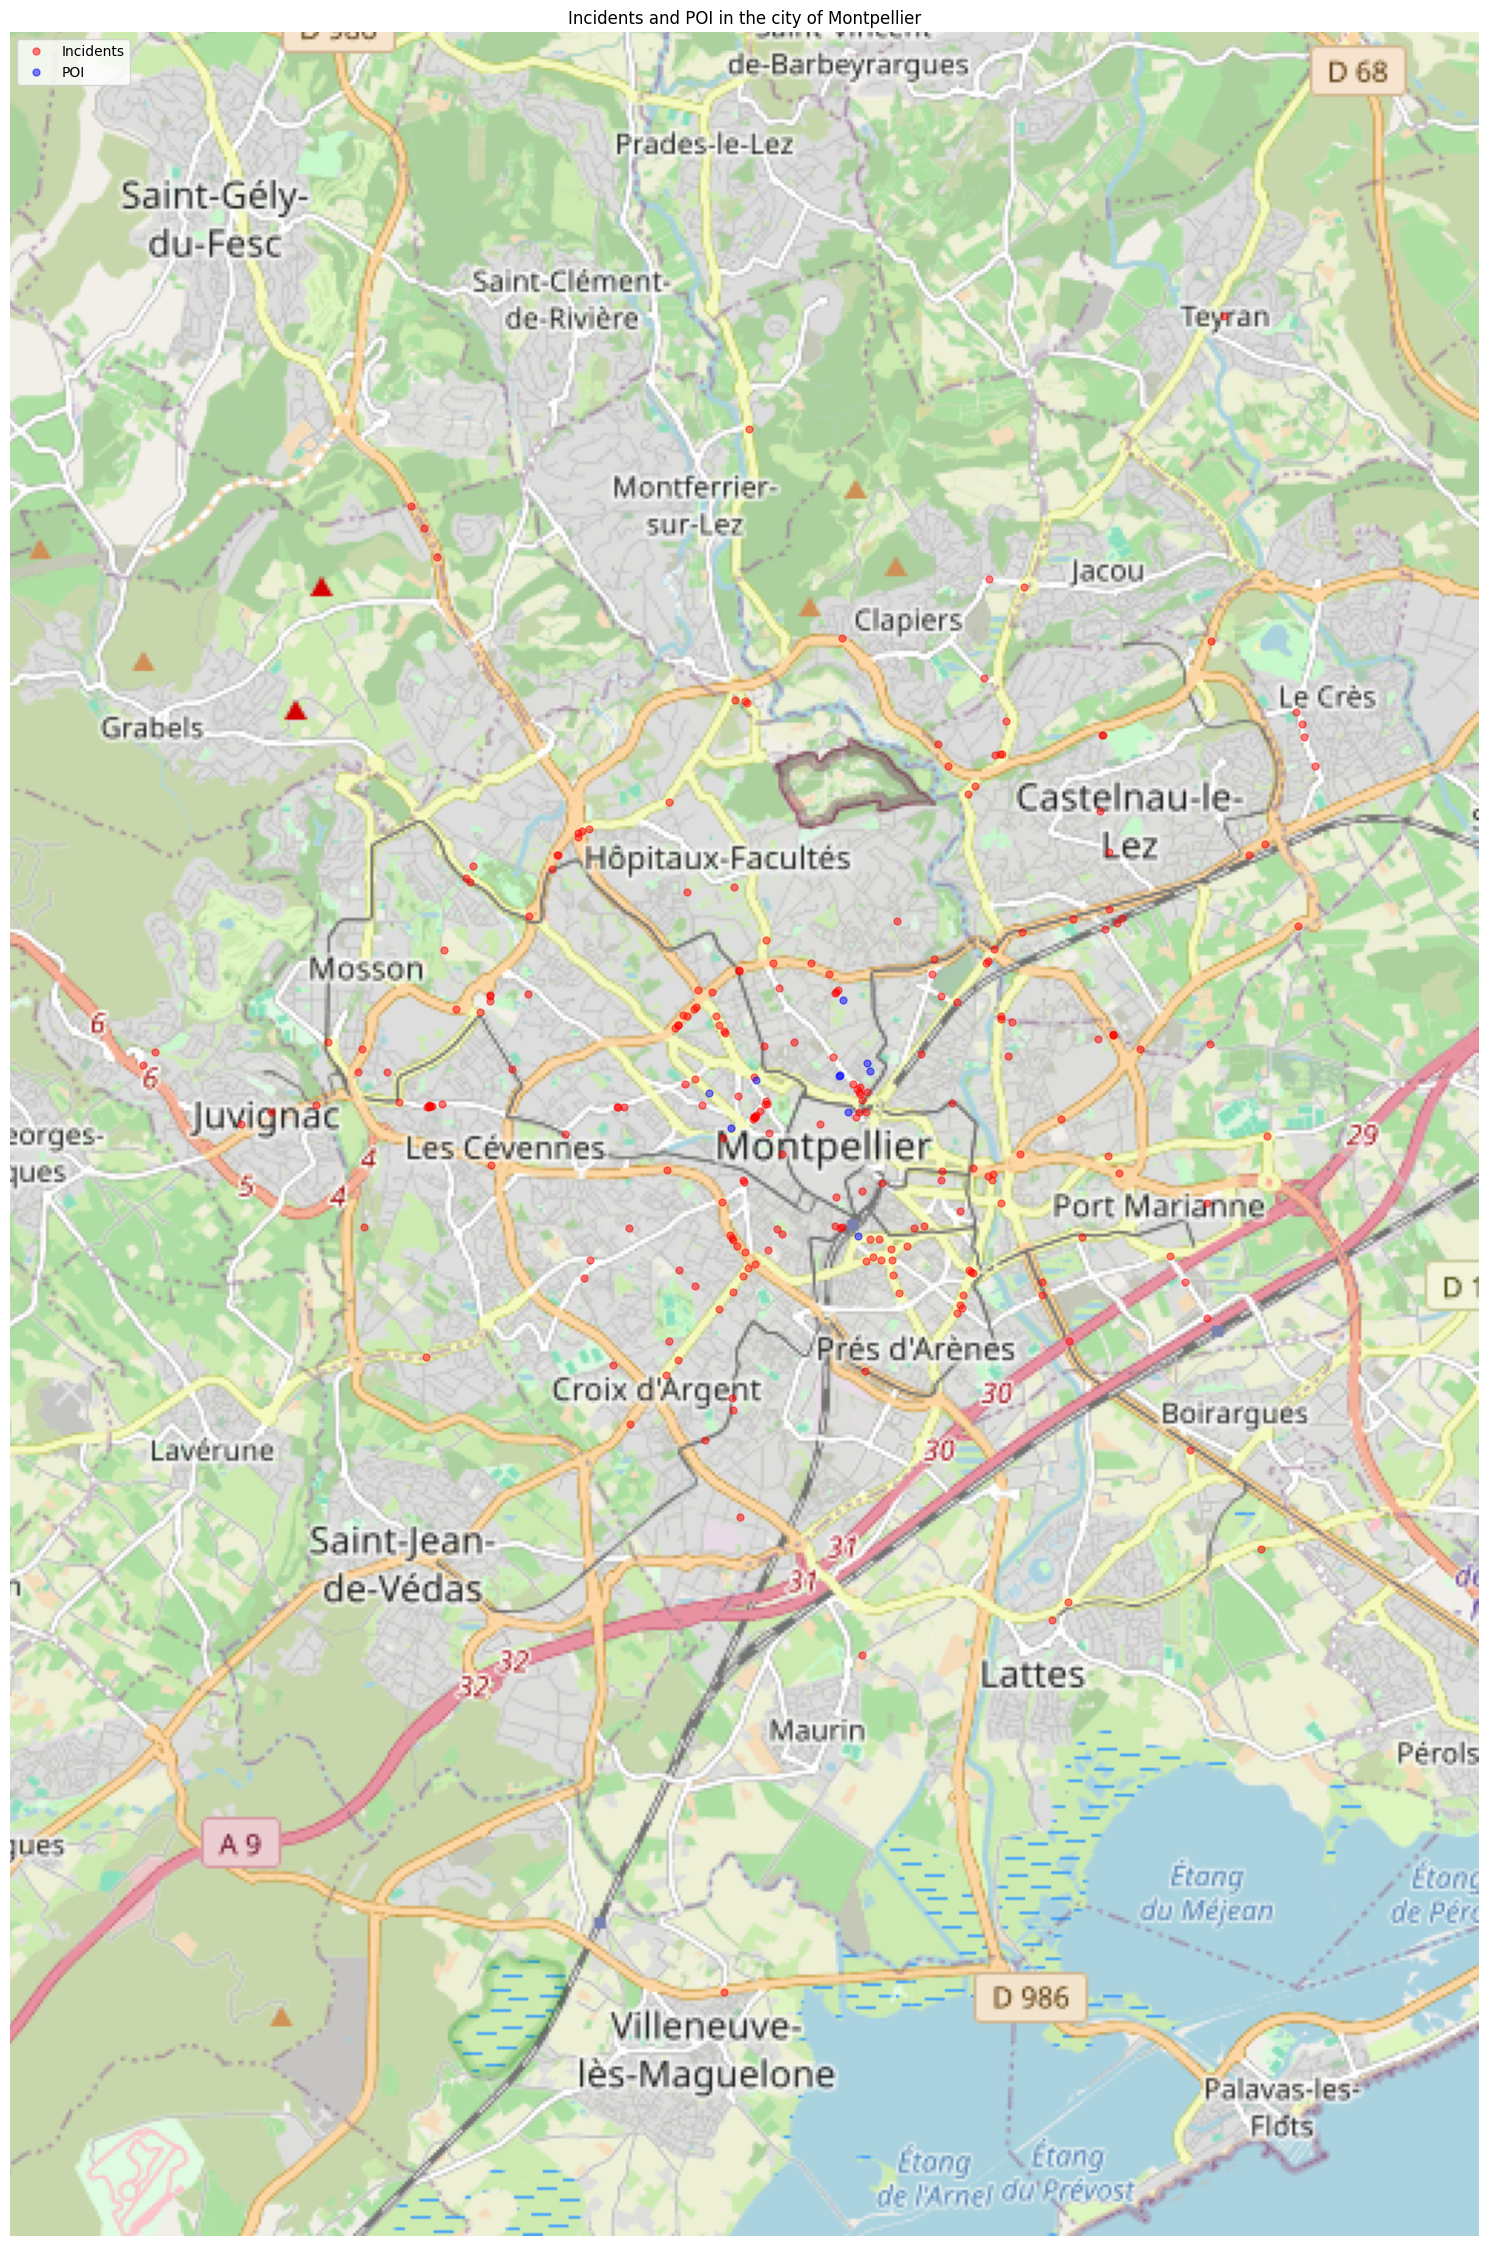

In [220]:
# Define central point and box with adjusted delta and zoom
lat = df_incidents['latitude'].mean()
lon = df_incidents['longitude'].mean()
delta = 0.05  # Adjusted for better zooming
box = (lat-delta, lon-delta, lat+delta, lon+delta)

# Create the map
map = smopy.Map(box, z=15)
ax = map.show_mpl(figsize=(15, 25))

# Plot the incidents
x, y = map.to_pixels(df_incidents['latitude'], df_incidents['longitude'])
ax.plot(x, y, 'or', ms=5, mew=1, alpha=0.5)

# Plot the POI
x, y = map.to_pixels(df_poi.head(10)['latitude'], df_poi.head(10)['longitude'])
ax.plot(x, y, 'ob', ms=5, mew=1, alpha=0.5)

# Add a legend
ax.legend(['Incidents', 'POI'])

# Add a title
ax.set_title('Incidents and POI in the city of Montpellier')

# Show the map
plt.show()

In [221]:
# Create a folium map
m = folium.Map(location=[lat, lon], zoom_start=15)

# Add the incidents as red dots
for i, incident in df_incidents.iterrows():
    folium.Marker([incident['latitude'], incident['longitude']],
                  icon=folium.Icon(color='red')).add_to(m)  

    
# Add the POI
for i, poi in df_poi.head(10).iterrows():
    folium.Marker([poi['latitude'], poi['longitude']],
                  popup=df_poi['name'][i] + ' - ' + str(df_poi['Number of incidents'][i]) + ' incidents',
                  icon=folium.Icon(color='blue')).add_to(m)


# Add a title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Siglaments concernant les stationnements gênants autour de Écoles et Crêches dans la ville de Montpellier</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))


# Add a legend
legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; left: 50px; width: 100px; height: 90px; 
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color: white;
                         ">&nbsp; <b>Legend</b> <br>
                           &nbsp; Incident &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                           &nbsp; POI &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
             </div>
             '''


# Display the map
m

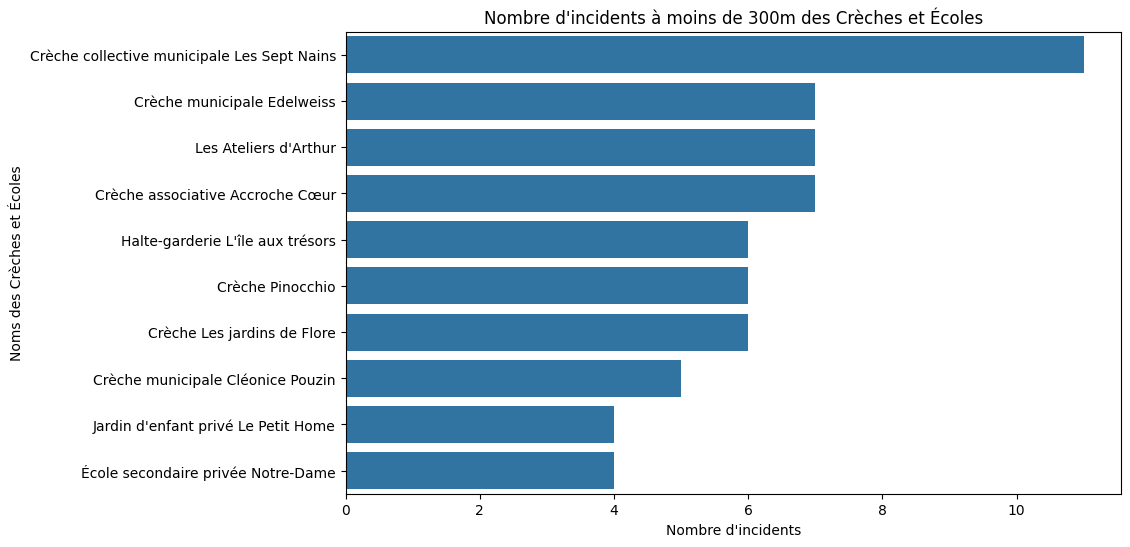

In [222]:
#Plot the number of incidents in the buffer for each POI
titre = None
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of incidents', y='name', data=df_poi.head(10))
plt.title(label=f'Nombre d\'incidents à moins de {BUFFER_SIZE}m des {NOM[0]} et {NOM[1]}' if not titre else titre)
plt.xlabel('Nombre d\'incidents')
plt.ylabel(f'Noms des {NOM[0]} et {NOM[1]}')
plt.show()
